<center>
<img src="https://raw.githubusercontent.com/FUlyankin/ekenam_grand_research/master/images/cover.png">
</center>


# <center> Иканам гранд рисёрч </center>
## <center>  Часть седьмая: моделирование </center>


Проект **Иканам гранд рисёрч** реализуется [Иканам стьюдентс коммьюнити,](https://vk.com/ikanam)
в частности [вот этим парнем по имени Филипп.](https://vk.com/ppilif)  Если вы нашли ошибку или у вас есть предложения, замечания, деньги, слава или женщины, можно ему написать. Весь говнокод, использованный в исследовании распостраняется по лицензии [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) Его можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу рисёрча.](https://github.com/FUlyankin/ekenam_grand_research) 


In [26]:
import warnings     # Игнорирование варнингов
warnings.filterwarnings("ignore")  

In [27]:
import numpy as np     # Нумпай для векторов 
import pandas as pd    # Пандас для табличек 
# Округлять в табличках значения до второго знака
pd.set_option('precision', 2)           

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

# Пакет для красивых циклов. При желании его можно отключить. Тогда из всех циклов придётся 
# удалять команду tqdm_notebook.
from tqdm import tqdm_notebook   # подробнее: https://github.com/tqdm/tqdm

In [28]:
%matplotlib inline  

Перейдём в папку с данными. Это новый финт. Так мы ешё не выпендривались. 

In [29]:
cd '../5. Data prepare'

/Users/fulyankin/Documents/ekanam_grand_research/5. Data prepare


# 1. Подгрузка данных и их дробление 

Все названия переменных я, конечно же копировал из прошлого файла. 

In [30]:
# Подгрузили файлик с описание переменных 
des_var = pd.read_csv('variables.csv', sep=';')
print(des_var.shape)

# Подгрузили самые полные данные. После очистки данных, некоторые фичи, которые есть в описании
# исчезли из таблички с данными.  Придётся взять пересечение столбцов и переменных из описания. 
data = pd.read_csv('data5_prof_ph_wl_pub.csv', sep='\t', index_col=False)

# проиндексируем табличку с переменными названиями 
des_var.set_index('name',inplace=True)
# возьмём ту её часть, которая соответствует колонкам 
des_var = des_var.ix[data.columns.get_values( ),:]
# сбрасываем индекс
des_var.reset_index(inplace=True)

# Создаём списки из переменных для картинок и скалирования 
real_set = set(des_var[des_var['type'] == 'real']['name'])
cnt_set= des_var[des_var['type'] == 'cnt']['name'].get_values()
cat_set = des_var[des_var['type'] == 'cat']['name'].get_values()
dummy_set = des_var[des_var['type'] == 'dummy']['name'].get_values()

# Откидываем переменные, к которым я отношусь скептически
print(des_var.shape)
bad_vars = des_var[des_var['my_opinion'] == -1]['name'].get_values()
des_var = des_var[des_var['my_opinion'] > -1]
print(des_var.shape)

des_var.head()

(196, 5)
(180, 5)
(100, 5)


,name,des,type,source,my_opinion
0,uids,id вконтакте,teh,profile,0.0
1,firstname,имя,teh,profile,0.0
2,lastname,фамилия,teh,profile,0.0
4,prohodnoy,проходной балл в год поступления,real,order,0.0
5,lgota,была ли льгота,dummy,order,1.0


In [31]:
# ешё одна подгрузка той же таблички для удобства
data = pd.read_csv('data5_prof_ph_wl_pub.csv', sep='\t', index_col=False)

# Выбрасываем разные не очень важные куски. Здесь мы будем то комментировать, то снимать комментарии и прогонять 
# дальше всё время один и тот же код для разных подвыборок 

# Выбрасываем переменные, которым я не верю 
data.drop(bad_vars, axis=1, inplace = True)

# выкинуть всех кто без id 
data.dropna(subset=['uids'],axis=0,inplace=True)

# 1.Технические переменные
data.drop(['profile_first_name', 'profile_last_name', 'wall_repost_groups_id','wall_repost_people_id',
           'wall_repost_groups_id', 'wall_repost_people_id'] ,axis=1, inplace = True)

# 2.Переменные по приказам
data.drop(['prohodnoy', 'kurs', 'zima', 'leto', 'akadem', 'target_2', 'target_3', 'target_4'], axis=1, inplace = True)

# data.drop(['lgota', 'chelevoe', 'olimp', 'dogovor', 'ochko-zaochka', 'ege_diff', 'kozko'], axis=1, inplace = True)

# 3. Субъективные переменные 
data.hodit_tusa.fillna(data.hodit_tusa.mean(), inplace= True)     # Внимание! В пеерменных остались пропуски
data.hodit_para.fillna(data.hodit_para.mean(), inplace = True)    # Заполняем их средними
data.drop([ 'hodit_para','hodit_tusa'], axis=1, inplace = True)

# 4. Переменные, которые отвечают за профиль
# Дамми
uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'dummy')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Счётчики 
uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'cnt')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Категориальные
# Заполним все пропуски каким-нибудь символом для выделения отдельных дамми под них
cat_vars = [var for var in data.columns if var in cat_set]
X_cat = pd.get_dummies(data[cat_vars].fillna('NA').applymap(str))
X_cat['uids'] = data.uids
# data = pd.merge(data,X_cat,on='uids', how='left')
data.drop('uids', axis=1, inplace=True)

uslovie = (des_var['source'] == 'profile')&(des_var['type'] == 'cat')
data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)


# 5. Переменные, которые отвечают за фотки
# Cчётчики
uslovie = (des_var['source'] == 'photo')&(des_var['type'] == 'cnt')
data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['source'] == 'photo')&(des_var['type'] == 'real')
data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)


# 6. Переменные, которые отвечают за стенку 
# Cчётчики
uslovie = (des_var['source'] == 'wall')&(des_var['type'] == 'cnt')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['source'] == 'wall')&(des_var['type'] == 'real')
# data.drop(des_var[uslovie]['name'].get_values() ,axis=1, inplace = True)

# Дамми
wl_dummy_var = ['wall_can_comment']
# data.drop(wl_dummy_var,axis=1, inplace = True)


# 7. Переменные, которые относятся к пабликам
pub_20_vars = ['20pub_clust_' + str(i) for i in range(20)]
data.drop(pub_20_vars, axis=1, inplace=True)

pub_30_vars = ['30pub_clust_' + str(i) for i in range(30)]
data.drop(pub_30_vars, axis=1, inplace=True)

data.head()

,firstname,lastname,year,lgota,chelevoe,olimp,dogovor,ochko-zaochka,ege_diff,kozko,...,wall_post_mweb_cnt,wall_post_original_cnt,wall_post_wphone_cnt,wall_repost_cnt,wall_repost_mean,wall_slowpok_hour_max,wall_text_len_max,wall_text_len_mean,wall_video_cnt,wall_video_mean
0,Данильченко,Леонид,2012,0,0.0,1,0,0,-44.0,0,...,0.0,0.0,0.0,2.0,0.13,9.07,1193.0,203.33,3.0,0.20
1,Лисовская,Людмила,2012,0,0.0,1,0,0,8.0,0,...,0.0,0.0,0.0,1.0,0.05,19.61,230.0,51.37,1.0,0.05
2,Кочеткова,Полина,2012,0,0.0,1,0,0,2.0,0,...,8.0,0.0,1.0,119.0,0.11,23.94,11919.0,154.10,80.0,0.07
3,Канаева,Дельгир,2012,1,0.0,0,0,0,-5.0,0,...,0.0,0.0,0.0,0.0,0.00,4.16,47.0,17.86,0.0,0.00
4,Климова,Екатерина,2012,1,0.0,0,0,0,-44.0,0,...,0.0,0.0,0.0,3.0,0.15,19.48,10139.0,1160.60,4.0,0.20


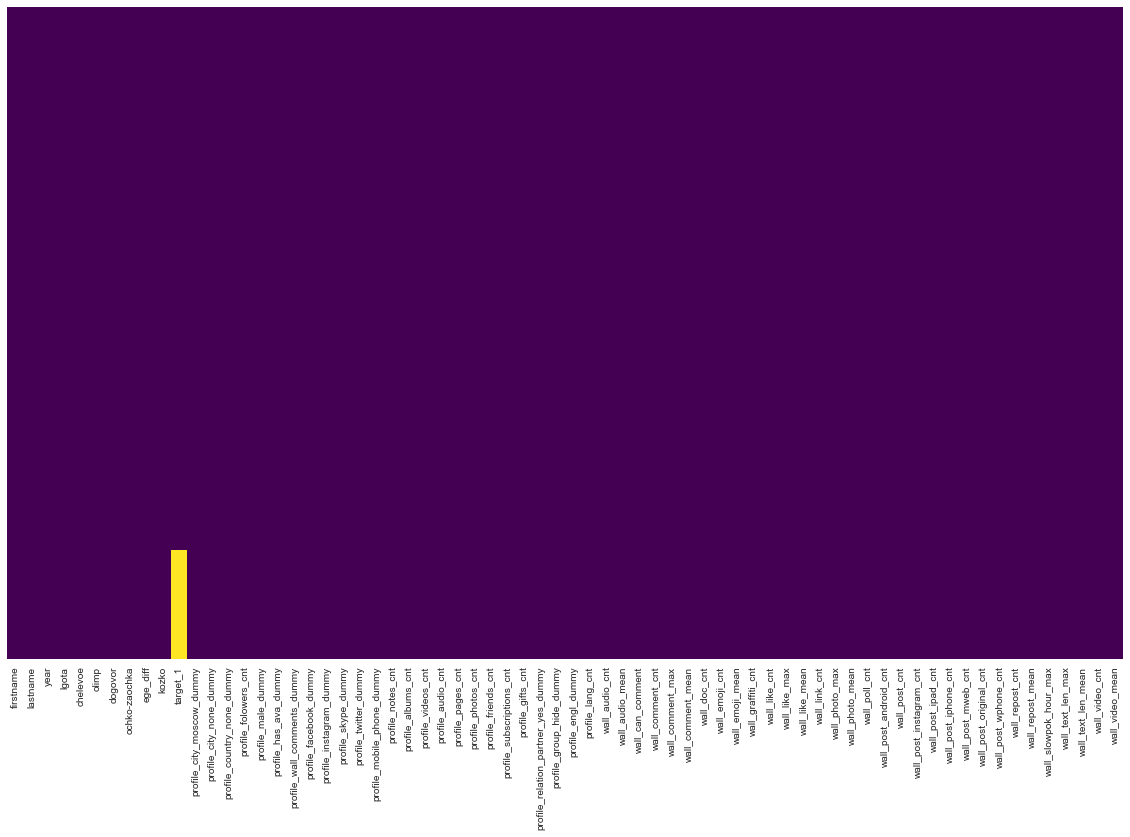

In [32]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [33]:
# Подмножества для опытов 
pub_wall = ['year','target_1','firstname', 'lastname',
            'ege_diff', 'wall_can_comment', 'wall_comment_max', 'wall_post_iphone_cnt',
            'wall_video_mean', '20pub_clust_0', '20pub_clust_3']

all_pub_20 = ['year','target_1','firstname', 'lastname',
              'ochko-zaochka', 'profile_folowers_cnt', 'profile_albums_cnt', 'photo_like_mean',
              'wall_can_comment', 'wall_emoji_mean', 'wall_post_android_cnt', 'wall_post_ipad_cnt',
              'wall_repost_mean', 'wall_video_cnt', 'wall_video_mean','20pub_clust_9', '20pub_clust_11']

#data = data[all_pub]

Разбиваем оставшуюся табличку на тестовую и тренировочную выборки. 

In [52]:
# Убираем 2017 год 
X_2017 = data[data.year == 2017].drop(['year','target_1'],axis=1)

# Запоминаем имена для прогнозов 
names_2017 = X_2017.firstname.get_values() + np.array([' ']*X_2017.shape[0]) + X_2017.lastname.get_values()
X_2017.drop(['firstname', 'lastname'], axis=1, inplace=True)

# Выделяем 2016 год как тестовую выборку 
X_test = data[data.year == 2015].drop(['year','target_1'],axis=1)
names_2016 = X_test.firstname.get_values() + np.array([' ']*X_test.shape[0]) + X_test.lastname.get_values()
X_test.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_test = data[data.year == 2015]['target_1'].get_values()

# Выделяем остальное как тернировочную выборку
X_train = data[(data.year != 2017)&(data.year != 2015)].drop(['year','target_1'],axis=1)
X_train.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_train = data[(data.year != 2017)&(data.year != 2015)]['target_1'].get_values()

# списки переменных для табличек
real_vars = [var for var in X_train.columns if var in real_set]
cnt_vars = [var for var in X_train.columns if var in cnt_set]
dummy_vars = [var for var in X_train.columns if var in dummy_set]

# Немного стандартизации для непрерывных переменных
from sklearn.preprocessing import StandardScaler  # Для непрерывных переменных 
from sklearn.preprocessing import MinMaxScaler    # Для счётчиков 
sscaler = StandardScaler()
mscaler = MinMaxScaler()

try:
    X_train[real_vars] = sscaler.fit_transform(X_train[real_vars])
    X_test[real_vars] = sscaler.transform(X_test[real_vars])
    X_2017[real_vars] = sscaler.transform(X_2017[real_vars])
except:
    print('Нет реальных переменных')

try:
    X_train[cnt_vars] = mscaler.fit_transform(X_train[cnt_vars])
    X_test[cnt_vars] = mscaler.transform(X_test[cnt_vars])
    X_2017[cnt_vars] = sscaler.transform(X_2017[cnt_vars])
except:
    print('Нет счётчиков')

    
# Мне влом переводить весь тот же самый код на R 
# Поэтому просто сохраняем нашу табличку для него
data1 = X_train.copy()
data1['target_1'] = y_train
data1.to_csv('train_data_for_R.csv', sep=';',header=True, index=False)
data2 = X_test.copy()
data2['target_1'] = y_test
data2.to_csv('test_data_for_R.csv', sep=';',header=True, index=False)

# Запоминаем в отдельный массив названия переменных 
varnames = X_train.columns.get_values()

# Вытаскиваем матрицы
X_train = X_train.get_values()
X_test = X_test.get_values()

print('\n Метки:', '\n', y_test[:10], '\n')
print('Переменные: \n', X_test[:2], '\n')

print('Всего:', data.shape)
print('Трэйн:', X_train.shape, y_train.shape)
print('Тест:', X_test.shape, y_test.shape)

print('Число переменных:', len(varnames))
# print('действительных: ' + str(len(real_vars)),'счётчиков: ' + str(len(cnt_vars)),
#       'дамми: ' + str(len(dummy_vars)),'категориальных: ' + str(len(cat_vars)), sep=', ')

Нет счётчиков

 Метки: 
 [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  1.] 

Переменные: 
 [[ 0.          0.          0.          0.          0.          0.86809391
   1.          1.          0.          0.          0.0626151   0.          1.
   1.          0.          0.          0.          0.          1.
   0.01149425  0.          0.01357628  0.17682784  0.02545969  0.
   0.03785638  0.          0.46846847  0.          0.          1.          0.6
   0.00726392 -0.38388723  1.          0.03205521  0.02159871  1.51899873
   0.          0.09968426  4.4332881   0.          0.23840659  0.16627473
   1.12626369  0.          0.91635682  0.09313017  0.          0.
   0.01105604  0.01052632  0.00593472  0.11860465  0.02912621  0.          0.
   0.05810398 -0.05749652  0.71208582  0.29649903 -0.05578379  0.02459016
  -0.09403384]
 [ 0.          0.          0.          0.          0.          0.21961794
   1.          0.          1.          1.          0.02246777  1.          0.
   1.          0.    

# 2. Константный прогноз 

Посмотрим на константный прогноз, чтобы было с чем сранвинвать. 

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

n_train = y_train.shape[0]
n_test = y_test.shape[0]

print('Трэйн:')
print('accuracy_0 :', accuracy_score(y_train, [0]*n_train))
print('accuracy_1 :', accuracy_score(y_train, [1]*n_train))
print('roc-auc:', roc_auc_score(y_train, np.ones(y_train.shape)))

print( '\n', 'Тест:')
print('accuracy_0 :', accuracy_score(y_test, [0]*n_test))
print('accuracy_1 :', accuracy_score(y_test, [1]*n_test))
print ('roc-auc:', roc_auc_score(y_test, np.ones(y_test.shape)))

Трэйн:
accuracy_0 : 0.290441176471
accuracy_1 : 0.709558823529
roc-auc: 0.5

 Тест:
accuracy_0 : 0.210526315789
accuracy_1 : 0.789473684211
roc-auc: 0.5


Вывод: любая модель с точностью менее 70% сразу отправляется на помойку. 

# 3. Регрессия - моя профессия 

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

# Функция для вывода метрик качества
def printer(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    print ('Train accuracy', accuracy_score(y_train, model.predict(X_train)))
    print ('Test accuracy', accuracy_score(y_test, model.predict(X_test)), '\n')
    print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
    print ('Test roc-auc', roc_auc_score(y_test, y_hat_test))
    
# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
  

 # Функция для отрисовки конфьюжн матрикс 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    

Качество на кросс-валидации: 0.477127192982 

Train accuracy 0.830882352941
Test accuracy 0.684210526316 

Train roc-auc 0.883190135764
Test roc-auc 0.622916666667


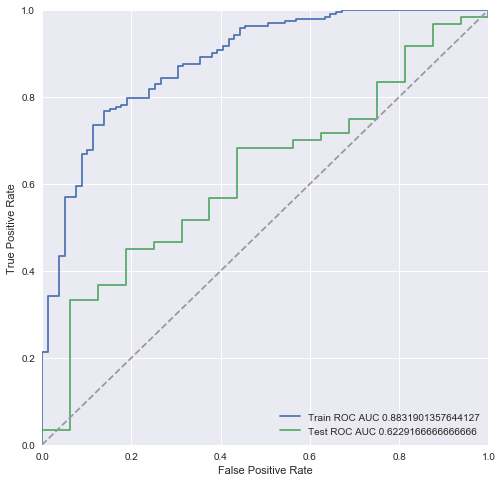

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

# Обучаем логистическую регрессию 
lr = LogisticRegression(C=10**10)
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)

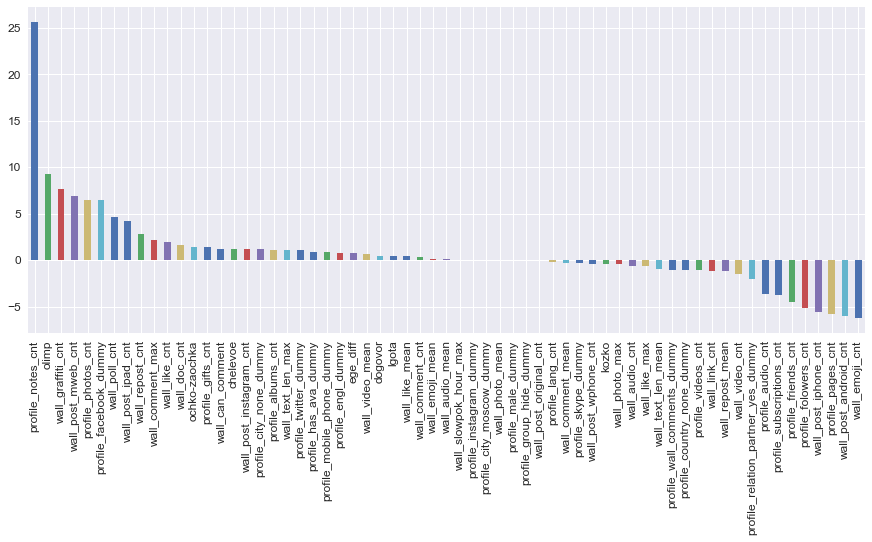

In [56]:
imps = pd.Series([cf for cf in lr.coef_[0]],index=varnames)

lasso_features = np.array(imps[imps != 0].index)

imps = imps.sort_values(ascending=False)[:len(lasso_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# Оставляем только незанулившиеся переменные 
ind_lasso = np.array([np.where(varnames == ft)[0][0] for ft in lasso_features])

# Решётка

In [57]:
from sklearn.grid_search import GridSearchCV

parameters_grid = {
    # 'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.0000000001, 5, num = 100)
}

gridsearch = GridSearchCV(LogisticRegression(penalty = 'l1', class_weight='balanced'), 
                            parameters_grid, scoring = 'roc_auc', cv = 5)

gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'C': 0.1010101011080808}

Качество на кросс-валидации: 0.666499662618 

Число переменных: 10
Train accuracy 0.709558823529
Test accuracy 0.671052631579 

Train roc-auc 0.732242408343
Test roc-auc 0.6375


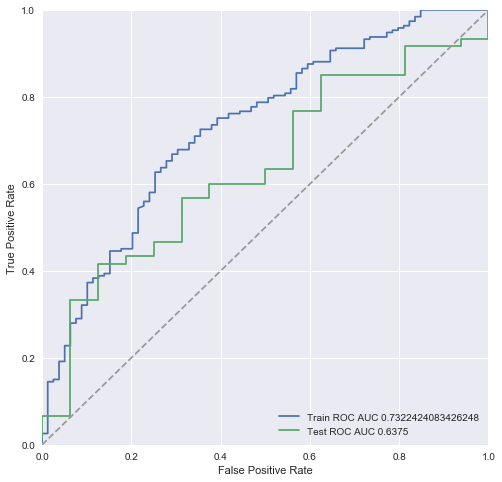

In [58]:
# Обучаем логистическую регрессию 
lr = LogisticRegression(penalty='l1', C = 0.1, class_weight='balanced')
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

print('Число переменных:', len([var for var in lr.coef_[0] if abs(var) > 0]))

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)

# 4. Отбор регрессоров 

## 4.1 Отбор переменных с помощью Lasso 

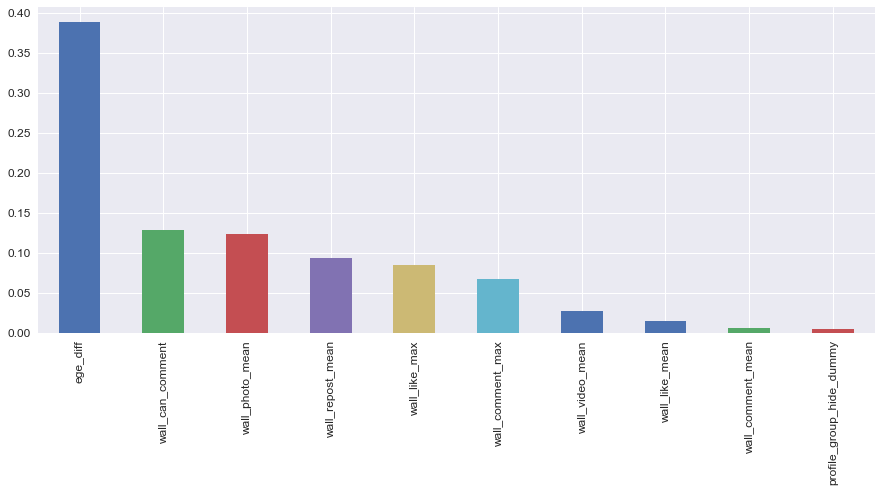

In [59]:
imps = pd.Series([abs(cf) for cf in lr.coef_[0]],index=varnames)

lasso_features = np.array(imps[imps > 0].index)

imps = imps.sort_values(ascending=False)[:len(lasso_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# Оставляем только незанулившиеся переменные 
ind_lasso = np.array([np.where(varnames == ft)[0][0] for ft in lasso_features])

In [60]:
X_train_sub = X_train[:,ind_lasso]
X_test_sub = X_test[:,ind_lasso]

##  Добавляем PCA 

In [18]:
from sklearn.decomposition import PCA
my_pca = PCA(n_components=5) 
X_tr_pca = my_pca.fit_transform(X_train)

lr_pca = LogisticRegression(C=10**10, class_weight='balanced')
lr_pca.fit(X_tr_pca, y_train)

scoring = cross_val_score(lr_tsne, X_tr_pca, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

X_test_pca = my_pca.transform(X_test)
printer(lr_pca, X_test=X_test_pca, X_train=X_tr_pca)

NameError: name 'lr_tsne' is not defined

In [47]:
X_train_2 = np.hstack((X_train_sub, X_tr_pca))
X_test_2 = np.hstack((X_test_sub, X_test_pca))
print(X_train_2.shape, X_test_2.shape)

scoring = cross_val_score(lr_pca, X_train_2, y_train, scoring = 'roc_auc', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')
lr_pca.fit(X_train_2, y_train)

printer(lr_pca, X_test=X_test_2, X_train=X_train_2)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Прогнозы 

In [61]:
lr_pred = lr#_pca
X_test_pr = X_test#_2

Average precision-recall score: 0.87


Text(0.5,1,'2-class Precision-Recall curve: AP=0.87')

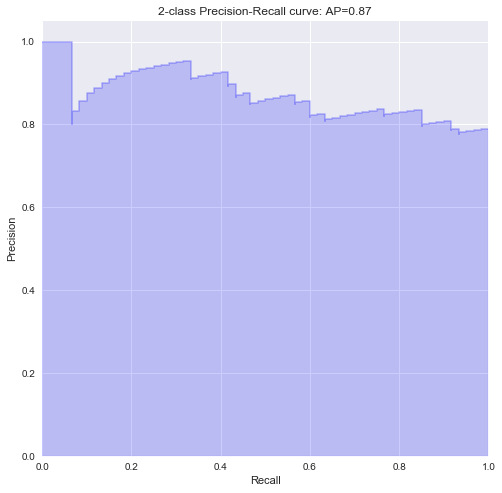

In [62]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_score = lr_pred.decision_function(X_test_pr)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

             precision    recall  f1-score   support

        0.0       0.20      0.06      0.10        16
        1.0       0.79      0.93      0.85        60

avg / total       0.66      0.75      0.70        76



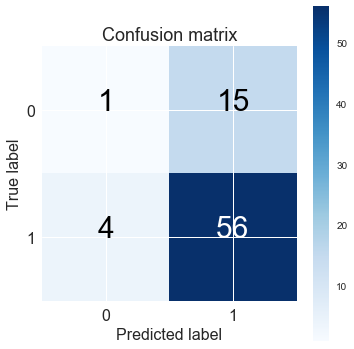

In [68]:
yht = 1*(lr_pred.predict_proba(X_test_pr)[:,-1] > 0.4)
cm = confusion_matrix(y_test, yht)
plot_confusion_matrix(cm, classes=['0', '1'])

report = classification_report(y_test, yht)
print(report)

In [64]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(lr_pred.predict_proba(X_test_pr)[:,-1],y_test))]
for a,b,c in sorted(name_pred, key=lambda w: w[1], reverse=True):
    print('',a, b, c,'' ,sep = '|')

|Андреев Даниил|0.923628763076|1.0|
|Шаброва Анастасия|0.87054914327|1.0|
|Селиванова Виктория|0.772329351103|1.0|
|Петров Илья|0.765697874634|1.0|
|Гильдин Марк|0.736691059464|0.0|
|Гареев Михаил|0.735567649148|1.0|
|Федорчук Яна|0.723685921401|1.0|
|Лобкова Дарья|0.699666058306|1.0|
|Стельмах  Юлия|0.664750240985|1.0|
|Касьянова Ксения|0.643714468984|1.0|
|Левит Виктория|0.642283510551|1.0|
|Васильева Александра|0.641904017949|1.0|
|Кулак Ксения|0.629082761069|1.0|
|Фоломеев Александр|0.621404877946|1.0|
|Гусевская Алина|0.619201232853|1.0|
|Иванова Наталья|0.615751709804|1.0|
|Распутняя Альбина|0.612348278667|1.0|
|Анищик Анастасия|0.607998499394|1.0|
|Яковлева Елизавета|0.607589215083|1.0|
|Суюнбаев Ислам|0.599847248028|1.0|
|Джаохадзе Елена|0.596849371577|1.0|
|Бурякова Анастасия|0.596719159416|0.0|
|Канцевич Дарья|0.594208663852|1.0|
|Антончиков Александр|0.580370608569|1.0|
|Найденович Анна|0.576071156217|1.0|
|Долбежова Марина|0.568171828089|1.0|
|Алексеева Дарья|0.567194248634

In [65]:
name_pred = [(a,b) for a, b in zip(names_2017, lr_pred.predict_proba(X_2017)[:,-1])]
for a,b in sorted(name_pred, key=lambda w: w[1], reverse=True):
    print('',a, b,'' ,sep = '|')

|Дарсигов Микаил|0.732482021609|
|Волкова Анна|0.728800162734|
|Зорькина Анастасия|0.704073743857|
|Кидло Ирина|0.701424310095|
|Потапов Владислав|0.687934070233|
|Габузова Елена|0.644828622429|
|Козлов Глеб|0.629626879467|
|Юрова Маргарита|0.626563344439|
|Маинскова Татьяна|0.621129490672|
|Анискина Валерия|0.602092320595|
|Беляков Юрий|0.596114221647|
|Бурмина Светлана|0.595384723068|
|Синицын Сергей|0.591532668673|
|Сарафанюк Юрий|0.588300677576|
|Еремеев Максим|0.587001983562|
|Нуртдинов Камиль|0.585979576098|
|Алиев Самир|0.584700836235|
|Курилкина Юлия|0.581638323438|
|Никишов Вадим|0.57726870774|
|Майорова  Ксения|0.577249940228|
|Леохина Александра|0.575157614165|
|Даниловская Виктория|0.574571468946|
|Владимирова Ольга|0.572886382336|
|Евстафьев Сергей|0.569029103686|
|Шишкин Никита|0.567902060086|
|Мантрова Екатерина|0.563878651821|
|Наумов Николай|0.563765681374|
|Третьяков Дмитрий|0.563698018279|
|Кичаев Денис|0.55696483044|
|Сороковнина Светлана|0.553421053487|
|Хупения  Н

In [25]:
pd.DataFrame(sorted(name_pred, key=lambda w: w[1], reverse=True)).to_csv('1_k.csv',sep='\t')

# 6. Простенькая нейросеточка

In [139]:
import keras
from keras.models import Sequential   # Последовательность слоёв
import keras.layers as L              # Разные слои
import keras.optimizers as opt        # Оптимизаторы
from keras.utils.np_utils import to_categorical  # Для преобразования y в категориальный формат 

In [140]:
def get_new_model(order):
    # Задаём модель и называем её Ахмед
    model = Sequential(name = 'Julia')

    # Добавляем в нашу модель первый слой из 20 нейронов
    # На вход в эти 25 нейронов будут индти все наши регрессоры
    model.add(L.Dense(8, input_dim = order, kernel_initializer='random_normal'))
    
    model.add(L.Dropout(0.5))
    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('relu'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(8, kernel_initializer='random_normal'))
    model.add(L.Dropout(0.5))
    model.add(L.Activation('relu'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 2 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))

    # В качестве оптимизации будем использовать Adam
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модельa
    model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    return model

In [141]:
np.random.seed(42)
model = get_new_model(X_train_sub.shape[1])

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 88        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
activation_4 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
Total para

In [143]:
np.random.seed(42)
hist = model.fit(X_train_sub, to_categorical(y_train), validation_split=0.2, epochs=140,
                   verbose=0)

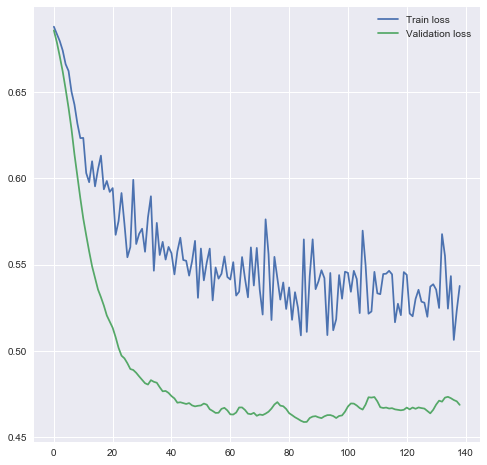

In [144]:
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [145]:
# Можно предсказать вероятности для тестовой выборки
model.predict_proba(X_test_sub)[:,-1]

array([ 0.88563699,  0.78639585,  0.58698916,  0.99339092,  0.58698916,
        0.54625326,  0.95458722,  0.57820374,  0.56766605,  0.81347972,
        0.62278652,  0.89023334,  0.93310618,  0.5942741 ,  0.67894286,
        0.86219913,  0.94637048,  0.65891463,  0.97022867,  0.98736167,
        0.60784662,  0.85132998,  0.69675326,  0.91439873,  0.90938181,
        0.68177474,  0.74135548,  0.79523492,  0.55416983,  0.74351799,
        0.87923086,  0.79960835,  0.63587177,  0.80524278,  0.83590537,
        0.99966097,  0.60045004,  0.58698916,  0.79842764,  0.73123932,
        0.75694567,  0.6579839 ,  0.57507586,  0.8833459 ,  0.64156014,
        0.71228844,  0.96871477,  0.71384722,  0.84721273,  0.60224354,
        0.5642572 ,  0.91894853,  0.8301084 ,  0.78662121,  0.55799896,
        0.71422243,  0.54778379,  0.70610231,  0.6103428 ,  0.79016501,
        0.7632131 ,  0.59532213,  0.60625178,  0.94320935,  0.5477221 ,
        0.63783169,  0.58698916,  0.57505888,  0.65055615,  0.54

In [146]:
# А можно классы 
model.predict_classes(X_test_sub)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

Train accuracy 0.730215827338
Validation accuracy 0.714285714286 

Train roc-auc 0.772183908046
Validation roc-auc 0.5775


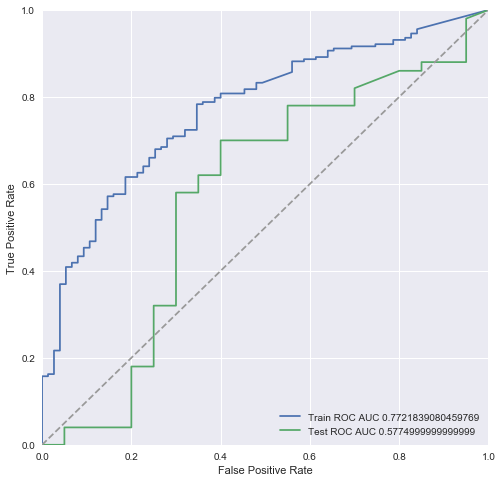

In [147]:
y_tr_hat_nn = model.predict_classes(X_train_sub)
y_ts_hat_nn = model.predict_classes(X_test_sub)

y_hat_train = model.predict_proba(X_train_sub)[:,-1]
y_hat_test = model.predict_proba(X_test_sub)[:,-1]

print ('Train accuracy', accuracy_score(y_train, y_tr_hat_nn))
print ('Validation accuracy', accuracy_score(y_test, y_ts_hat_nn), '\n')
print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
print ('Validation roc-auc', roc_auc_score(y_test, y_hat_test))


fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
roc_auc_train = roc_auc_score(y_train, y_hat_train)
roc_auc_test = roc_auc_score(y_test, y_hat_test)

matplotlib.rcParams['figure.figsize'] = (8, 8)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

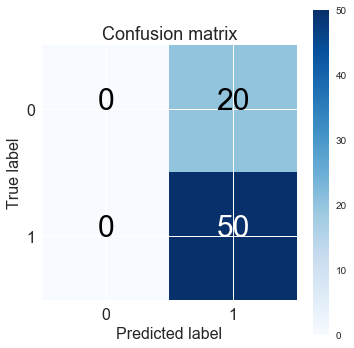

In [148]:
cm = confusion_matrix(y_test, y_ts_hat_nn)
plot_confusion_matrix(cm, classes=['0', '1'])

In [149]:
report = classification_report(y_test, lr.predict(X_test))
print(report)

             precision    recall  f1-score   support

        0.0       0.46      0.65      0.54        20
        1.0       0.83      0.70      0.76        50

avg / total       0.73      0.69      0.70        70



             precision    recall  f1-score   support

        0.0       0.34      0.96      0.50        75
        1.0       0.96      0.32      0.47       203

avg / total       0.79      0.49      0.48       278

0.489208633094


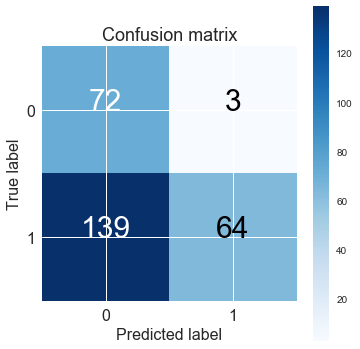

In [150]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_train)[:,-1] > 0.6)

report = classification_report(y_train, yhtr)
print(report)

print(accuracy_score(y_train, yhtr))

cm = confusion_matrix(y_train, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        20
        1.0       0.71      1.00      0.83        50

avg / total       0.51      0.71      0.60        70

0.714285714286


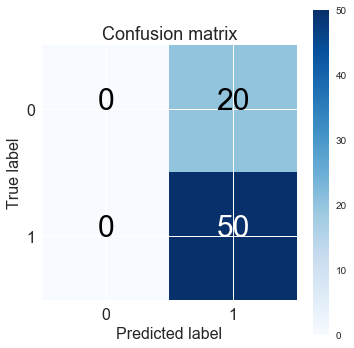

In [151]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_test)[:,-1] > 0.2)

report = classification_report(y_test, yhtr)
print(report)

print(accuracy_score(y_test, yhtr))

cm = confusion_matrix(y_test, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

In [ ]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(model.predict_proba(X_test_sub)[:,-1],y_test))]
sorted(name_pred, key=lambda w: w[1], reverse=True)

# 7. Деревья 

In [ ]:
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,max_features='sqrt',random_state=42)
rf.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(rf, X_train, y_train, scoring = 'accuracy', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

printer(rf)
roc_auc_pic(rf)

# 8.  Xgboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

gbm = xgb.XGBClassifier( )

gbm_param_grid = {
    "colsample_bytree" : np.linspace(0.2,1,num=10),
    "subsample" : np.linspace(0.2,1,num=10),
    "n_estimators" : range(10,50),
    "max_depth" : range(2,12),
    "learning_rate": np.linspace(0,0.2,num=10),
    "gamma": np.linspace(0,10,num=21),
    #'reg_alpha': np.linspace(0,50,num=21),
    "min_child_weight": np.linspace(0,20,num=21)
}

# Если выборка большая, ставить 1000 итераций - плохая идея, так как будет обучаться 4000 моделей
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                                    scoring="accuracy", cv=4, verbose=1,n_iter=1000)

randomized_mse.fit(X_train,y_train)

print("Лучшие параметры: ", randomized_mse.best_params_)
print('\n')
print("Самый крутой accuracy: ", randomized_mse.best_score_)

printer(randomized_mse)

## 6. TSNE 

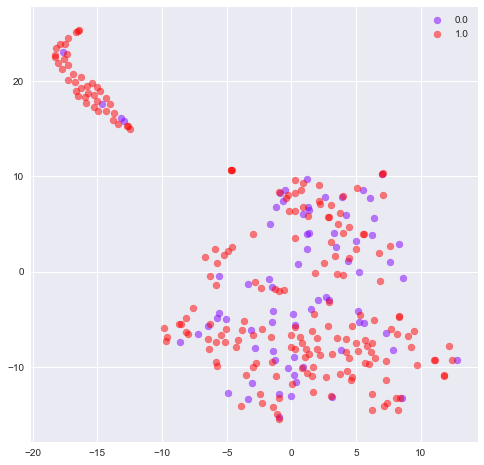

In [245]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

My_TSNE = TSNE(random_state=321)
tsne_representation = My_TSNE.fit_transform(X_train)

y = y_train

colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for yy,c in zip(set(y), colors):
    plt.scatter(tsne_representation[y == yy, 0],
                tsne_representation[y == yy, 1], c=c, alpha = 0.5, label = str(yy))
plt.legend()

In [247]:
data.ix[tsne_representation[:,0] < -10].head() 

,firstname,lastname,year,lgota,chelevoe,olimp,dogovor,ochko-zaochka,ege_diff,kozko,...,30pub_clust_20,30pub_clust_21,30pub_clust_22,30pub_clust_23,30pub_clust_24,30pub_clust_25,30pub_clust_26,30pub_clust_27,30pub_clust_28,30pub_clust_29
0,Данильченко,Леонид,2012,0,0.0,1,0,0,-44.0,0,...,2.22e-03,2.06e-03,0.03,1.41e-03,2.17e-03,9.21e-02,9.42e-03,5.37e-03,8.72e-02,6.87e-04
2,Кочеткова,Полина,2012,0,0.0,1,0,0,2.0,0,...,4.33e-03,2.42e-02,0.04,1.08e-03,4.11e-03,9.21e-02,6.56e-03,1.89e-02,4.31e-02,0.00e+00
3,Канаева,Дельгир,2012,1,0.0,0,0,0,-5.0,0,...,4.48e-03,1.57e-02,0.01,0.00e+00,0.00e+00,1.07e-01,1.52e-03,4.37e-02,1.34e-02,1.79e-02
11,Нагшбанди,Рабиа,2012,0,0.0,0,0,0,26.0,0,...,4.46e-03,1.60e-01,0.01,1.84e-03,4.71e-03,7.56e-03,1.07e-02,9.77e-03,1.44e-03,8.56e-04
15,Шабалина,Ольга,2012,0,0.0,0,0,0,21.0,0,...,1.12e-02,3.31e-02,0.09,1.48e-03,2.23e-03,1.15e-02,7.39e-03,2.26e-02,8.25e-02,2.59e-04


In [280]:
My_TSNE = TSNE(random_state=321)
tsne_representation = My_TSNE.fit_transform(np.vstack((X_train,X_test)))

X_tsne_train = tsne_representation[:X_train.shape[0],:]
X_tsne_test = tsne_representation[X_train.shape[0]:X_train.shape[0]+X_test.shape[0],:]                                       

In [281]:
lr_tsne = LogisticRegression(C=10**10)
lr_tsne.fit(X_tsne_train, y_train)

scoring = cross_val_score(lr_tsne, X_tsne_train, y_train, scoring = 'roc_auc', cv =5)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

printer(lr_tsne,X_test = X_tsne_test, X_train=X_tsne_train)

Качество на кросс-валидации: 0.62506504065 

Train accuracy 0.726618705036
Test accuracy 0.714285714286 

Train roc-auc 0.632906403941
Test roc-auc 0.512


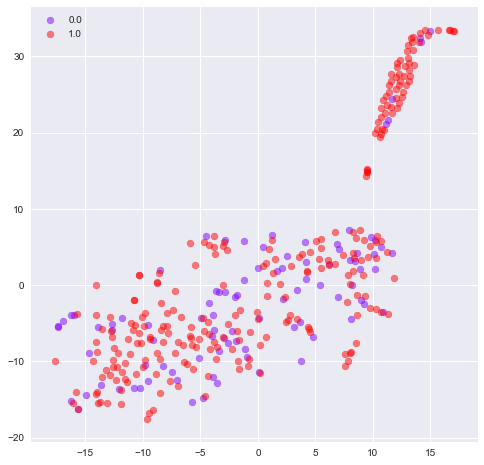

In [282]:
y = np.array(list(y_train) + list(y_test))

colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for yy,c in zip(set(y), colors):
    plt.scatter(tsne_representation[y == yy, 0],
                tsne_representation[y == yy, 1], c=c, alpha = 0.5, label = str(yy))
plt.legend()

In [272]:
data.ix[tsne_representation[:,1] > 10][['firstname','lastname']]

,firstname,lastname
0,Данильченко,Леонид
2,Кочеткова,Полина
3,Канаева,Дельгир
11,Нагшбанди,Рабиа
15,Шабалина,Ольга
16,Ольхова,Ольга
35,Упатова,Яна
42,Глазова,Александра
46,Головко,Алексей
48,Ульянкин,Филипп


# 6. Ансамбль 

In [ ]:
a = 'tab_num|year_month|Date_nachala_raboty|Date_nachala_raboty_erkc|year_quarter|Work_erkc_3m|Work_erkc_6m|Work_erkc_12m|vk_has_photo|vk_has_mobile|vk_cnt_albums|vk_cnt_audios|vk_cnt_followers|vk_cnt_gifts|vk_cnt_groups|vk_cnt_notes|vk_cnt_pages|vk_cnt_photos|vk_cnt_subscriptions|vk_cnt_user_photos|vk_cnt_videos|vk_cnt_friends|vk_share_friends_sberbank|vk_share_friends_women|vk_share_friends_men|vk_interest_topic_0|vk_interest_topic_1|vk_interest_topic_2|vk_interest_topic_3|vk_interest_topic_4|vk_interest_topic_5|vk_interest_topic_6|vk_interest_topic_7|vk_interest_topic_8|vk_interest_topic_9|vk_interest_topic_10|vk_interest_topic_11|vk_interest_topic_12|vk_interest_topic_13|vk_interest_topic_14|vk_interest_topic_15|vk_interest_topic_16|vk_interest_topic_17|vk_interest_topic_18|vk_interest_topic_19|Solution_Data|HTline_general|HTline_verbal|HTline_erudit|HTline_numeric|HTline_info|HTline_int_ext|HTline_independence|HTline_selfcontrol|HTline_anxiety|HTline_conservatism|HTline_quiet|HTline_active|HTline_simple|HTline_complex|HTline_min_communucation|HTline_max_communication|HTline_single|HTline_team|HTline_subordite|HTline_domint|HTline_reglamented|HTline_free|HTline_constant|HTline_project|HTline_quiet_active|HTline_easy_complex|HTline_min_max_communication|HTline_single_team|HTline_subord_domint|HTline_regl_free|HTline_const_project|HTline__lider|HTline__team|HTline__client|HTline_system|HTline_comm_infl|HTline_mp|HTline_int_ext_profile|HTline_indep_sogl_profile|HTline_info_process_profile|Lang_cnt_top3_lev3|Lang_cnt_top3_lev2|Lang_me_lev|Lang_cnt_all|Lang_flag|Lang_cnt_all_lev2|Lang_asia_lev|Lang_other_flag|Lang_ee_flag|Lang_cnt_all_lev1|Lang_cnt_top3|Lang_ca_flag|Lang_cnt_all_lev3|Lang_asia_flag|Lang_ee_lev|Lang_cnt_top3_lev1|Lang_we_flag|Lang_other_lev|Lang_Caucasus_flag|Lang_eng_lev|Lang_ca_lev|Lang_we_lev|Lang_me_flag|Lang_Caucasus_lev|vk_photo_ava_change_cnt|vk_photo_cnt|vk_photo_like_cnt|vk_photo_like_max|vk_photo_like_mean|vk_photo_like_median|vk_photo_repost_cnt|vk_photo_repost_max|vk_photo_repost_mean|vk_photo_repost_median|vk_photo_text_len_cnt|vk_photo_text_len_max|vk_photo_text_len_mean|vk_photo_text_len_median|vk_photo_text_url_len_cnt|vk_photo_wall_ph_post_cnt|vk_wall_album_cnt|vk_wall_album_max|vk_wall_album_mean|vk_wall_album_median|vk_wall_app_cnt|vk_wall_app_max|vk_wall_app_mean|vk_wall_app_median|vk_wall_audio_cnt|vk_wall_audio_max|vk_wall_audio_mean|vk_wall_audio_median|vk_wall_can_comment|vk_wall_comment_cnt|vk_wall_comment_max|vk_wall_comment_mean|vk_wall_comment_median|vk_wall_doc_cnt|vk_wall_doc_max|vk_wall_doc_mean|vk_wall_doc_median|vk_wall_emoji_cnt|vk_wall_emoji_max|vk_wall_emoji_mean|vk_wall_emoji_median|vk_wall_graffiti_cnt|vk_wall_graffiti_max|vk_wall_graffiti_mean|vk_wall_graffiti_median|vk_wall_lag_minute_mean|vk_wall_lag_minute_median|vk_wall_like_cnt|vk_wall_like_max|vk_wall_like_mean|vk_wall_like_median|vk_wall_link_cnt|vk_wall_link_max|vk_wall_link_mean|vk_wall_link_median|vk_wall_market_album_cnt|vk_wall_market_album_max|vk_wall_market_album_mean|vk_wall_market_album_median|vk_wall_market_cnt|vk_wall_market_max|vk_wall_market_mean|vk_wall_market_median|vk_wall_note_cnt|vk_wall_note_max|vk_wall_note_mean|vk_wall_note_median|vk_wall_page_cnt|vk_wall_page_max|vk_wall_page_mean|vk_wall_page_median|vk_wall_photo_cnt|vk_wall_photo_max|vk_wall_photo_mean|vk_wall_photo_median|vk_wall_photos_list_cnt|vk_wall_photos_list_max|vk_wall_photos_list_mean|vk_wall_photos_list_median|vk_wall_poll_cnt|vk_wall_poll_max|vk_wall_poll_mean|vk_wall_poll_median|vk_wall_post_android_cnt|vk_wall_post_cnt|vk_wall_post_instagram_cnt|vk_wall_post_ipad_cnt|vk_wall_post_iphone_cnt|vk_wall_post_len_cnt|vk_wall_post_len_max|vk_wall_post_len_mean|vk_wall_post_len_median|vk_wall_post_mob_cnt|vk_wall_post_original_cnt|vk_wall_post_other_cnt|vk_wall_post_reply_cnt|vk_wall_post_web_cnt|vk_wall_post_widget_cnt|vk_wall_post_wphone_cnt|vk_wall_posted_photo_cnt|vk_wall_posted_photo_max|vk_wall_posted_photo_mean|vk_wall_posted_photo_median|vk_wall_repost_cnt|vk_wall_repost_group_cnt|vk_wall_repost_max|vk_wall_repost_mean|vk_wall_repost_median|vk_wall_repost_user_cnt|vk_wall_sticker_cnt|vk_wall_sticker_max|vk_wall_sticker_mean|vk_wall_sticker_median|vk_wall_video_cnt|vk_wall_video_max|vk_wall_video_mean|vk_wall_video_median|sd_russian_citizen_nflag|sd_resident_nflag|crd_tot_act_qty|crd_dc_act_nflag|crd_cc_act_nflag|crd_act_to_tot_pct|crd_otf_cc_to_dc_rub_pct|prd_mb_active_nflag|prd_ib_active_nflag|cred_tot_os_to_inf_rub_pct|cred_tot_os_to_in_rub_pct|tot_os_to_inf_prcntl_pct|tot_os_to_in_prcntl_pct|cred_pl_os_to_inf_rub_pct|cred_pl_os_to_in_rub_pct|pl_os_to_inf_prcntl_pct|pl_os_to_in_prcntl_pct|cred_tot_pmt_to_inf_rub_amt|cred_tot_pmt_to_in_rub_amt|tot_pmt_to_inf_prcntl_pct|tot_pmt_to_in_prcntl_pct|crd_cc_overdue_nflag|lne_tot_dq_entr_ever_qty|prd_mg_active_nflag|prd_pl_active_nflag|crd_cc_utilization_pct|prd_da_active_nflag|prd_sc_active_nflag|prd_ap_total_active_nv|crd_otf_cc_cash_rub_nflag|crd_pos_eat_to_in_rub_pct|crd_pos_eat_to_spend_rub_pct|eat_to_in_prcntl_pct|eat_to_spend_prcntl_pct|crd_pos_leis_to_in_rub_pct|crd_pos_leis_to_spend_rub_pct|leis_to_in_prcntl_pct|leis_to_spend_prcntl_pct|crd_pos_tour_to_in_rub_pct|crd_pos_tour_to_spend_rub_pct|tour_to_in_prcntl_pct|tour_to_spend_prcntl_pct|crd_pos_bty_to_in_rub_pct|crd_pos_bty_to_spend_rub_pct|bty_to_in_prcntl_pct|bty_to_spend_prcntl_pct|crd_pos_med_to_in_rub_pct|crd_pos_med_to_spend_rub_pct|med_to_in_prcntl_pct|med_to_spend_prcntl_pct|crd_pos_healthcare_rub_pctll|crd_pos_healthcare_qty|crd_pos_eat_out_qty|crd_pos_eat_out_rub_pctl|crd_pos_leisure_qty|crd_pos_leisure_rub_pctl|crd_pos_tourism_qty|crd_pos_tourism_rub_pctl|crd_pos_beuaty_qty|crd_pos_beuaty_rub_pctl|crd_pos_healthcare_rub_pctl|geo_drive_optimistic_dur|geo_drive_pessimistic_dur|geo_drive_best_dur|geo_drive_dur|geo_drive_dist|geo_trans_dur|geo_trans_dist|geo_walk_dur|geo_walk_dist|cnt_vuz|has_sr_spec_obraz|years_after_vuz|is_student|years_in_vuz|uch_stepen|uch_stepen_binar|vuz_economic|vuz_economic_binar|vuz_human|vuz_human_binar|vuz_natural|vuz_natural_binar|vuz_tech|vuz_tech_binar|vuz_digital|vuz_digital_binar|vuz_other|vuz_other_binar|vuz_no_data|vuz_class_count|CSI_3m|CSI_6m|CSI_12m|Gend|Gend_id|Age|age_when_start_in_sber_nv|age_when_start_in_erkc|children|Date_of_Birth|Generation|Generation_num|zodiac_name|zodiac_num|season_name|season_num|cnt_vuz_interval|vuz_graduate'

In [ ]:
for var in a.split('|'):
    print(var)

<img align="center" src="http://img0.reactor.cc/pics/post/ванга-мемгенератор-59018.jpeg" width="300">
